Running FIXED NextClosure Algorithm...
Found 6 concepts:
Intents: [[], ['3'], ['2', '3'], ['1'], ['1', '3'], ['1', '2', '3']]


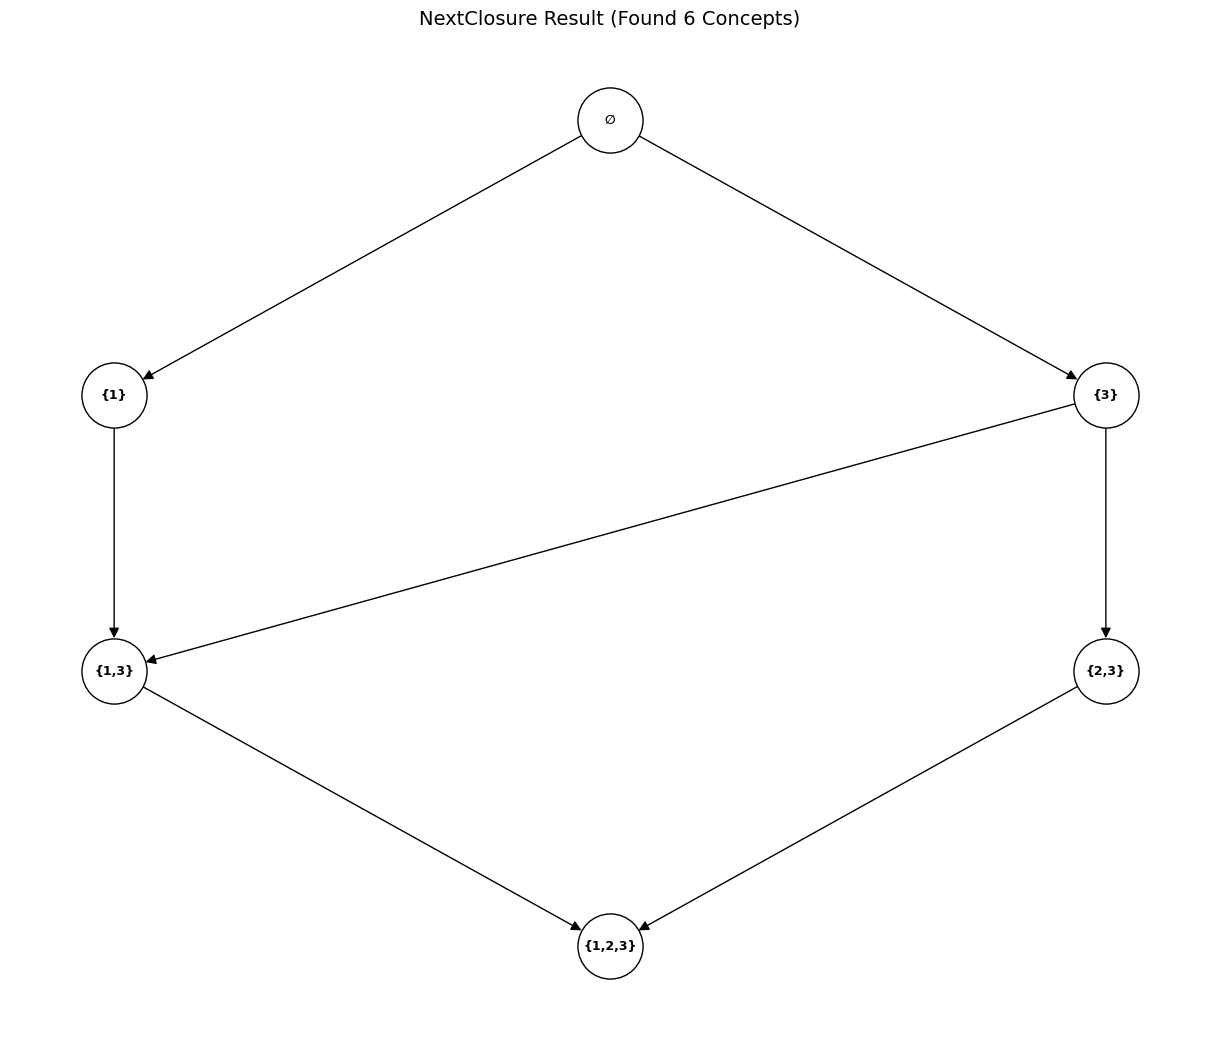

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# ==========================================
# 1. FIXED: NextClosure Algorithm
# ==========================================

def closure(attributes, G, M, I):
    # Standard closure operator A''
    objects = {g for g in G if all((g, m) in I for m in attributes)}
    if not objects:
        return set(M)
    closed_attrs = {m for m in M if all((g, m) in I for g in objects)}
    return closed_attrs

def get_all_intents_next_closure(G, M, I):
    """
    Implements Ganter's NextClosure algorithm correctly.
    """
    # 1. Start with the smallest concept (Closure of empty set)
    #    This is usually the Top concept in the diagram
    A = closure(set(), G, M, I)
    intents = [A]
    
    while A != set(M):
        # Find the "next" concept A+
        new_A = None
        
        # Iterate backwards through attributes (n down to 1)
        # We look for the largest 'i' that we can add to A
        for i_idx in reversed(range(len(M))):
            m_i = M[i_idx]
            
            # Skip if A already has this attribute (we can't add it)
            if m_i in A:
                continue
            
            # Construct Candidate: (A intersection {elements before i}) UNION {i}
            # "Keep everything before i, drop everything after i, add i"
            prefix = {M[j] for j in range(i_idx) if M[j] in A}
            candidate_set = prefix.union({m_i})
            
            # Calculate Closure
            B = closure(candidate_set, G, M, I)
            
            # --- THE CRITICAL FIX ---
            # Check Ganter's Condition:
            # The new concept B must NOT contain any "new" elements smaller than m_i.
            # i.e., B minus A should not have any element with index < i_idx
            
            valid_candidate = True
            for check_idx in range(i_idx): # Check all indices BEFORE i
                m_check = M[check_idx]
                # If B has it, but A (prefix) didn't...
                if m_check in B and m_check not in A:
                    valid_candidate = False # We skipped a step! Reject.
                    break
            
            if valid_candidate:
                new_A = B
                break # Found the lexicographically next concept!
        
        if new_A is None:
            break # Should not happen if logic is correct until we hit Top
            
        A = new_A
        intents.append(A)
        
    return intents

# ==========================================
# 2. DATA (Biological Context)
# ==========================================
G_bio = {'x1', 'x2', 'x3' , 'x4'}
M_bio = ['1', '2', '3']

I_bio = {
   ('x1', '1'), ('x1', '2'),('x1', '3'),
    ('x2', '1'), ('x2', '3'),
    ('x3', '2'), ('x3', '3'),
    ('x4', '1')
}

# ==========================================
# 3. DRAWING
# ==========================================
def build_and_draw(intents):
    nodes = [frozenset(intent) for intent in intents]
    G_full = nx.DiGraph()
    G_full.add_nodes_from(nodes)
    
    for A in nodes:
        for B in nodes:
            if A != B and A.issubset(B):
                G_full.add_edge(A, B)
    
    G_lattice = nx.transitive_reduction(G_full)

    plt.figure(figsize=(12, 10))
    labels = {}
    for node in G_lattice.nodes():
        if len(node) == 0: labels[node] = "∅"
        else:
            sorted_attrs = sorted(list(node), key=lambda x: str(x))
            labels[node] = "{" + ",".join(sorted_attrs) + "}"
            
    for node in G_lattice.nodes(): G_lattice.nodes[node]['layer'] = len(node)
    pos = nx.multipartite_layout(G_lattice, subset_key='layer', align='horizontal')
    pos = {node: (x, -y) for node, (x, y) in pos.items()} 

    nx.draw(G_lattice, pos, labels=labels, with_labels=True, node_size=2200, node_color="white", edgecolors="black", font_size=9, font_weight="bold", arrowstyle="-|>", arrowsize=15)
    plt.title(f"NextClosure Result (Found {len(G_lattice.nodes())} Concepts)", fontsize=14)
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
print("Running FIXED NextClosure Algorithm...")
all_intents = get_all_intents_next_closure(G_bio, M_bio, I_bio)

# Print sorted results to verify against the book/image
sorted_list = [sorted(list(x), key=str) for x in all_intents]
print(f"Found {len(all_intents)} concepts:")
# Print first 5 and last 5 to save space
print(f"Intents: {sorted_list[:]}")


build_and_draw(all_intents)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


# Closure + Extent functions


def extent(attributes, G, I):
    """
    Compute A' = objects having all attributes in A.
    """
    return {g for g in G if all((g, m) in I for m in attributes)}

def closure(attributes, G, M, I):
    """
    Compute A'' = intent closure of a set of attributes.
    """
    objects = extent(attributes, G, I)
    return {m for m in M if all((g, m) in I for g in objects)}


# NextClosure with Intent + Extent Output

def next_closure(G, M, I):
    """
    Returns list of (extent, intent) pairs in lectic order.
    """

    def lectic(A, B, i):
        """
        Ganter lectic order test.
        """
        for j in range(i):
            if M[j] in B and M[j] not in A:
                return False
        return True

    # Start with closure of empty set
    A = closure(set(), G, M, I)
    results = [(extent(A, G, I), A)]

    while True:
        found = False

        for i in reversed(range(len(M))):
            
            #iterating through {1, 2, ..., i-1} and making intersection with A

            prefix = {M[j] for j in range(i) if M[j] in A}

            if M[i] in A:
                continue

            #prefix union {M[i]} {A intersection {1, 2, ..., i-1} union {i}}
            
            candidate = prefix | {M[i]}
            
            #closure to secure closed set since candidate may not be closed due to union
            B = closure(candidate, G, M, I)

            if lectic(A, B, i):
                A = B
                results.append((extent(A, G, I), A))
                found = True
                break

        if not found:
            break

        if A == set(M):
            break

    return results



# test

G_bio = {'leech', 'bream', 'frog', 'dog', 'spike-weed', 'reed', 'bean', 'maize'}
M_bio = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

I_bio = {
   ('leech', '1'), ('leech', '2'), ('leech', '7'),
    
    # Bream (a, b, g, h -> 1, 2, 7, 8)
    ('bream', '1'), ('bream', '2'), ('bream', '7'), ('bream', '8'),
    
    # Frog (a, b, c, g, h -> 1, 2, 3, 7, 8)
    ('frog', '1'), ('frog', '2'), ('frog', '3'), ('frog', '7'), ('frog', '8'),
    
    # Dog (a, c, g, h, i -> 1, 3, 7, 8, 9)
    ('dog', '1'), ('dog', '3'), ('dog', '7'), ('dog', '8'), ('dog', '9'),
    
    # Spike-weed (a, b, d, f -> 1, 2, 4, 6)
    ('spike-weed', '1'), ('spike-weed', '2'), ('spike-weed', '4'), ('spike-weed', '6'),
    
    # Reed (a, b, c, d, f -> 1, 2, 3, 4, 6)
    ('reed', '1'), ('reed', '2'), ('reed', '3'), ('reed', '4'), ('reed', '6'),
    
    # Bean (a, c, d, e -> 1, 3, 4, 5)
    ('bean', '1'), ('bean', '3'), ('bean', '4'), ('bean', '5'),
    
    # Maize (a, c, d, f -> 1, 3, 4, 6)
    ('maize', '1'), ('maize', '3'), ('maize', '4'), ('maize', '6'),
}


# NextClosure with Intent + Extent Output

intent_extent_pair = next_closure(G_bio, M_bio, I_bio)

print("\n=== EXTENT – INTENT pairs ===\n")
for ext, intent in intent_extent_pair:
    print(f"{sorted(ext)}, {sorted(intent)}")




=== EXTENT – INTENT pairs ===

['bean', 'bream', 'dog', 'frog', 'leech', 'maize', 'reed', 'spike-weed'], ['1']
['bream', 'dog', 'frog', 'leech'], ['1', '7']
['bream', 'dog', 'frog'], ['1', '7', '8']
['bean', 'maize', 'reed', 'spike-weed'], ['1', '4']
['maize', 'reed', 'spike-weed'], ['1', '4', '6']
['bean', 'dog', 'frog', 'maize', 'reed'], ['1', '3']
['dog', 'frog'], ['1', '3', '7', '8']
['dog'], ['1', '3', '7', '8', '9']
['bean', 'maize', 'reed'], ['1', '3', '4']
['maize', 'reed'], ['1', '3', '4', '6']
['bean'], ['1', '3', '4', '5']
['bream', 'frog', 'leech', 'reed', 'spike-weed'], ['1', '2']
['bream', 'frog', 'leech'], ['1', '2', '7']
['bream', 'frog'], ['1', '2', '7', '8']
['reed', 'spike-weed'], ['1', '2', '4', '6']
['frog', 'reed'], ['1', '2', '3']
['frog'], ['1', '2', '3', '7', '8']
['reed'], ['1', '2', '3', '4', '6']
[], ['1', '2', '3', '4', '5', '6', '7', '8', '9']



=== Formal Concepts (extent, intent) ===

Extent = ['bean', 'bream', 'dog', 'frog', 'leech', 'maize', 'reed', 'spike-weed']   Intent = ['1']
Extent = ['bream', 'dog', 'frog', 'leech']   Intent = ['1', '7']
Extent = ['bream', 'dog', 'frog']   Intent = ['1', '7', '8']
Extent = ['bean', 'maize', 'reed', 'spike-weed']   Intent = ['1', '4']
Extent = ['maize', 'reed', 'spike-weed']   Intent = ['1', '4', '6']
Extent = ['bean', 'dog', 'frog', 'maize', 'reed']   Intent = ['1', '3']
Extent = ['dog', 'frog']   Intent = ['1', '3', '7', '8']
Extent = ['dog']   Intent = ['1', '3', '7', '8', '9']
Extent = ['bean', 'maize', 'reed']   Intent = ['1', '3', '4']
Extent = ['maize', 'reed']   Intent = ['1', '3', '4', '6']
Extent = ['bean']   Intent = ['1', '3', '4', '5']
Extent = ['bream', 'frog', 'leech', 'reed', 'spike-weed']   Intent = ['1', '2']
Extent = ['bream', 'frog', 'leech']   Intent = ['1', '2', '7']
Extent = ['bream', 'frog']   Intent = ['1', '2', '7', '8']
Extent = ['reed', 'spike-weed']   Int

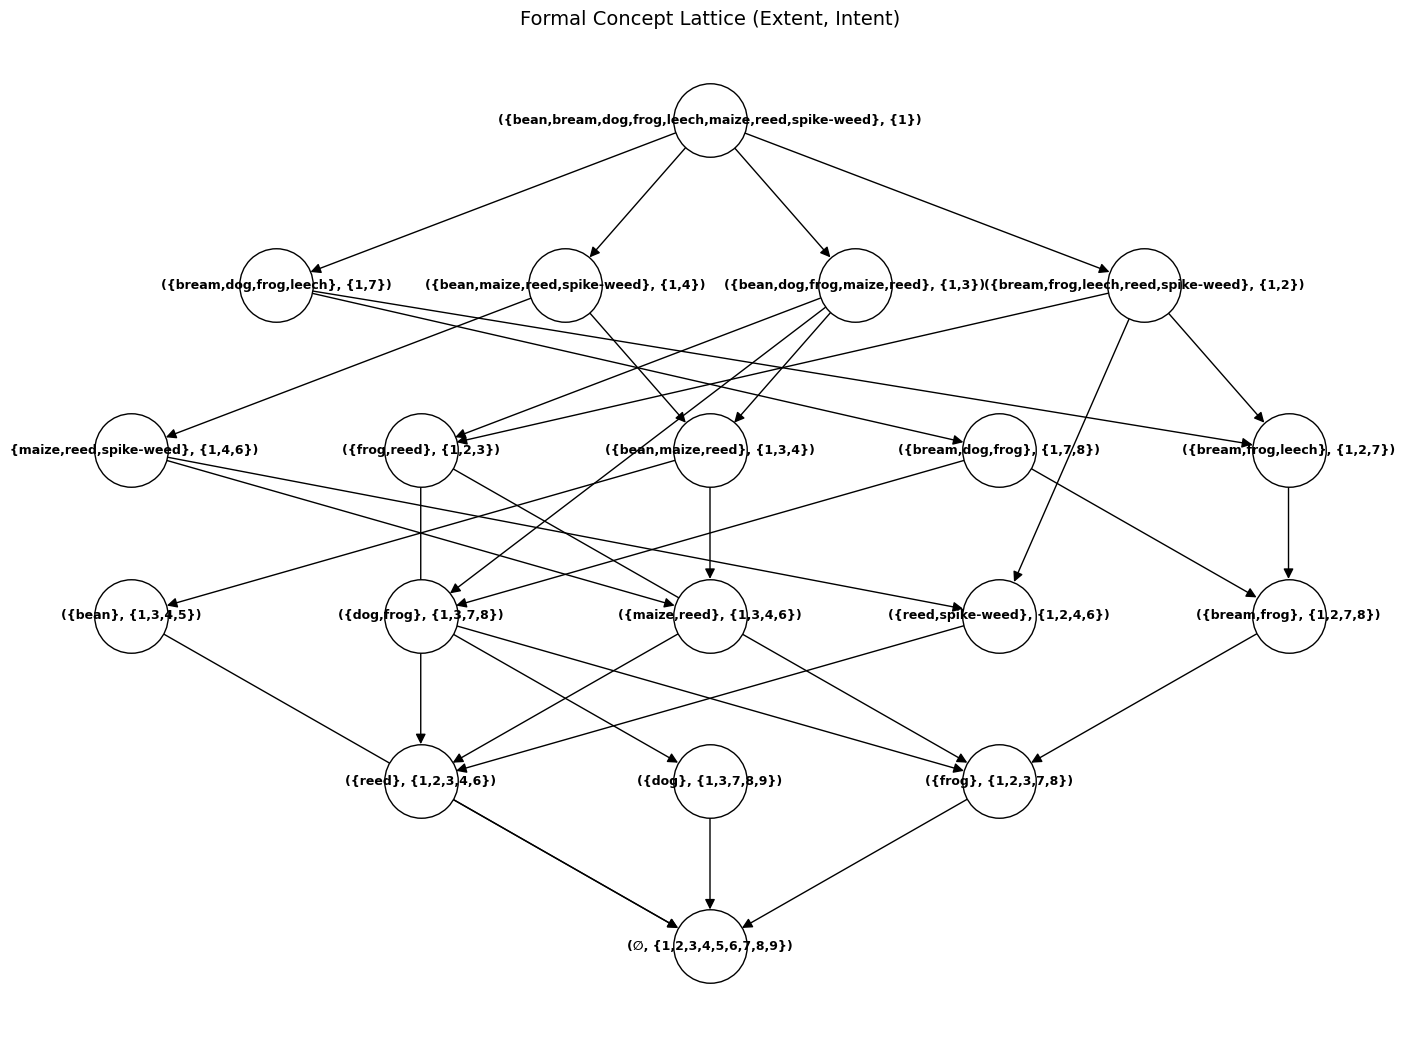

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# ============================================================
# 1. FCA Operators
# ============================================================

def extent(attributes, G, I):
    return {g for g in G if all((g, m) in I for m in attributes)}

def closure(attributes, G, M, I):
    objs = extent(attributes, G, I)
    return {m for m in M if all((g, m) in I for g in objs)}

# ============================================================
# 2. NextClosure (returns formal concepts)
# ============================================================

def next_closure(G, M, I):

    def lectic(A, B, i):
        for j in range(i):
            if M[j] in B and M[j] not in A:
                return False
        return True

    A = closure(set(), G, M, I)
    concepts = [(extent(A, G, I), A)]

    while True:
        found = False

        for i in reversed(range(len(M))):

            prefix = {M[j] for j in range(i) if M[j] in A}

            if M[i] in A:
                continue

            candidate = prefix | {M[i]}
            B = closure(candidate, G, M, I)

            if lectic(A, B, i):
                A = B
                concepts.append((extent(A, G, I), A))
                found = True
                break

        if not found:
            break

        if A == set(M):
            break

    return concepts


# ============================================================
# 3. Draw Lattice (Hasse Diagram)
# ============================================================

def draw_lattice(concepts):

    # Convert to frozensets for graph nodes
    nodes = [ (frozenset(ext), frozenset(intn)) for ext, intn in concepts ]

    # Create a directed graph
    G = nx.DiGraph()
    G.add_nodes_from(nodes)

    # Add edges for subset ordering of intents (classical concept lattice)
    for (E1, I1) in nodes:
        for (E2, I2) in nodes:
            if I1 < I2:  # proper subset
                G.add_edge((E1, I1), (E2, I2))

    # Reduce to Hasse diagram
    H = nx.transitive_reduction(G)

    # Node labels
    def format_set(S):
        if not S:
            return "∅"
        return "{" + ",".join(sorted(S)) + "}"

    labels = {}
    for (ext, intent) in H.nodes():
        labels[(ext, intent)] = f"({format_set(ext)}, {format_set(intent)})"

    # Layers = by size of intent
    for node in H.nodes():
        ext, intent = node
        H.nodes[node]["layer"] = len(intent)

    pos = nx.multipartite_layout(H, subset_key="layer", align="horizontal")
    pos = {n: (x, -y) for n, (x, y) in pos.items()}

    plt.figure(figsize=(14, 10))
    nx.draw(
        H, pos,
        with_labels=True,
        labels=labels,
        node_size=2800,
        node_color="white",
        edgecolors="black",
        font_size=9,
        font_weight="bold",
        arrowsize=15
    )
    plt.title("Formal Concept Lattice (Extent, Intent)", fontsize=14)
    plt.show()


# ============================================================
# 4. Test Example (Your Biological Context)
# ============================================================

G_bio = {'leech', 'bream', 'frog', 'dog', 'spike-weed', 'reed', 'bean', 'maize'}
M_bio = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
I_bio = {
  ('leech', '1'), ('leech', '2'), ('leech', '7'),
    
    # Bream (a, b, g, h -> 1, 2, 7, 8)
    ('bream', '1'), ('bream', '2'), ('bream', '7'), ('bream', '8'),
    
    # Frog (a, b, c, g, h -> 1, 2, 3, 7, 8)
    ('frog', '1'), ('frog', '2'), ('frog', '3'), ('frog', '7'), ('frog', '8'),
    
    # Dog (a, c, g, h, i -> 1, 3, 7, 8, 9)
    ('dog', '1'), ('dog', '3'), ('dog', '7'), ('dog', '8'), ('dog', '9'),
    
    # Spike-weed (a, b, d, f -> 1, 2, 4, 6)
    ('spike-weed', '1'), ('spike-weed', '2'), ('spike-weed', '4'), ('spike-weed', '6'),
    
    # Reed (a, b, c, d, f -> 1, 2, 3, 4, 6)
    ('reed', '1'), ('reed', '2'), ('reed', '3'), ('reed', '4'), ('reed', '6'),
    
    # Bean (a, c, d, e -> 1, 3, 4, 5)
    ('bean', '1'), ('bean', '3'), ('bean', '4'), ('bean', '5'),
    
    # Maize (a, c, d, f -> 1, 3, 4, 6)
    ('maize', '1'), ('maize', '3'), ('maize', '4'), ('maize', '6'),
}

concepts = next_closure(G_bio, M_bio, I_bio)

print("\n=== Formal Concepts (extent, intent) ===\n")
for E, Iset in concepts:
    print(f"Extent = {sorted(E)}   Intent = {sorted(Iset)}")

draw_lattice(concepts)
